# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
import lzma
import numpy as np
import random
import gymnasium as gym
import typing
from metadrive import MetaDriveEnv

from utils.env import State, Observation, Action, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor, get_metadrive_state, next_state, normalize_angle
from utils.transition_model_def import TransitionModel
from utils.idm_model_def import InverseDynamicsModel, idm_train_batch
from utils.model import set_lr_on_step, deviceof
from utils.in_memory_scenario_env import InMemoryScenarioEnv
from utils.loader import getFiles
from utils.waymo_loader import extract_trajectory_file, extract_scenarios_file


from torch.utils.data import TensorDataset, DataLoader
import itertools
import matplotlib.pyplot as plt

# CHANGE ME: Set this to the path to the Waymo Open Dataset root directory
WAYMO_DATA_PATH = "~/data/waymo"

2023-09-08 20:26:05.082191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 20:26:06.138270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
file_iter = iter(getFiles(WAYMO_DATA_PATH))
trajectories: list[list[State]] = []

In [3]:
for file_path in file_iter:
    trajectories_in_file = extract_trajectory_file(file_path)
    trajectories.extend(trajectories_in_file)
    print(f"Loaded {len(trajectories_in_file)} trajectories from {file_path}.")

2023-09-08 18:54:27.284248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 18:54:27.304411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 18:54:27.304617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loaded 61 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00000-of-01000.
Loaded 72 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00001-of-01000.
Loaded 64 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00002-of-01000.
Loaded 65 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00003-of-01000.
Loaded 65 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00004-of-01000.
Loaded 84 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00005-of-01000.
Loaded 68 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00006-of-01000.
Loaded 65 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00007-of-01000.
Loaded 57 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00008-of-01000.
Loaded 58 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00009-of-01000.
Loaded 72 trajectories from /home/fidget

KeyboardInterrupt: 

In [4]:
# pickle the trajectories
if not os.path.exists('./data/waymo/trajectories.pkl.xz'):
    with lzma.open('./data/waymo/trajectories.pkl.xz', 'wb') as f:
        pickle.dump(trajectories, f)

In [3]:
# unpickle and decompress
if "trajectories" not in locals():
    with lzma.open('./data/waymo/trajectories.pkl.xz', 'rb') as f:
        trajectories: list[list[State]] = pickle.load(f)

In [4]:
idm_data: list[Observation] = []
for states in trajectories:
    for i in range(len(states)-1):
        idm_data.append(Observation(states[i], states[i+1]))

# 90:10 train-validation split
idm_train_data = idm_data[:int(len(idm_data)*0.9)]
idm_validation_data = idm_data[int(len(idm_data)*0.9):]

In [5]:
print("train data:", len(idm_train_data))
print("validation data:", len(idm_validation_data))

train data: 947734
validation data: 105304


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
tm = TransitionModel().to(device)
tm.load_state_dict(torch.load('data/mm.pth'))

<All keys matched successfully>

Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [13]:
idm_train_dataset = TensorDataset(
    obs_batch_to_tensor(idm_train_data, torch.device("cpu")),
    state_batch_to_tensor([o.state for o in idm_train_data], torch.device("cpu")),
    state_batch_to_tensor([o.next_state for o in idm_train_data], torch.device("cpu"))
)
idm_train_loader = DataLoader(idm_train_dataset, batch_size=8192, shuffle=True)
idm_train_iter = itertools.cycle(iter(idm_train_loader))

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [19]:
IDM_LRS = {
    0: 8e-4,
    10000: 3e-4,
    15000: 1e-4,
    20000: 3e-5,
    25000: 1e-5,
}
IDM_TRAIN_EPOCHS = 25_000

while idm_step < IDM_TRAIN_EPOCHS:
    set_lr_on_step(idm_step, idm_optimizer, IDM_LRS)
    obs_tensor, s0_tensor, s1_tensor = next(idm_train_iter)
    loss = idm_train_batch(
        tm,
        idm,
        idm_optimizer,
        obs_tensor,
        s0_tensor,
        s1_tensor,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 1000 == 0:
        # print average loss over last 100 steps
        loss = np.mean(idm_losses[-1000:])
        print(f"Step: {idm_step}, Loss: {loss:.6f}")

Step: 15000, Loss: 0.000047
Set learning rate to 0.0001 on step 15000
Step: 16000, Loss: 0.000041
Step: 17000, Loss: 0.000040


KeyboardInterrupt: 

In [8]:
# load idm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('./data/waymo/idm.pth'))    

In [29]:
# save idm
if not os.path.exists('./data/waymo/idm.pth'):
    torch.save(idm.state_dict(), './data/waymo/idm.pth')

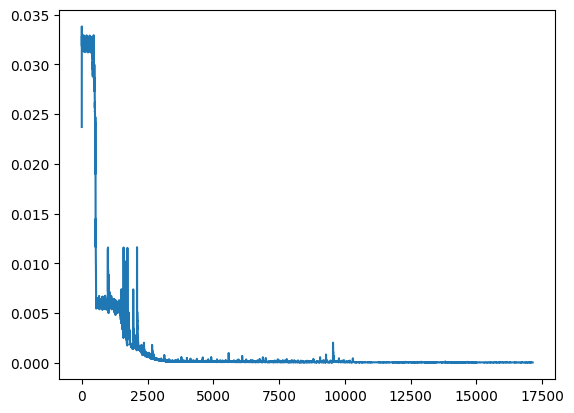

In [20]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

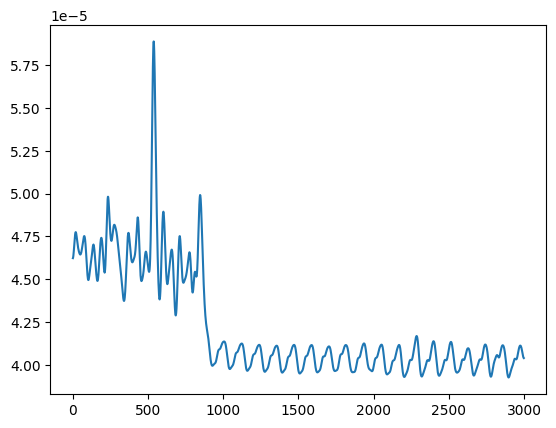

In [21]:
from scipy.ndimage import gaussian_filter1d

# plot the average reward per episode
idm_losses_averaged = gaussian_filter1d(idm_losses[-3000:], sigma=10)
plt.plot(idm_losses_averaged)

Let' compare our trained IDM against the null idm (predicts 0 for all values):

In [22]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([o.state for o in obs_batch], device)
s1_tensor = state_batch_to_tensor([o.next_state for o in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = tm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 3.966947042499669e-05


In [9]:
obs_batch = idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([o.state for o in obs_batch], device)
s1_tensor = state_batch_to_tensor([o.next_state for o in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = tm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 6.204406236065552e-05


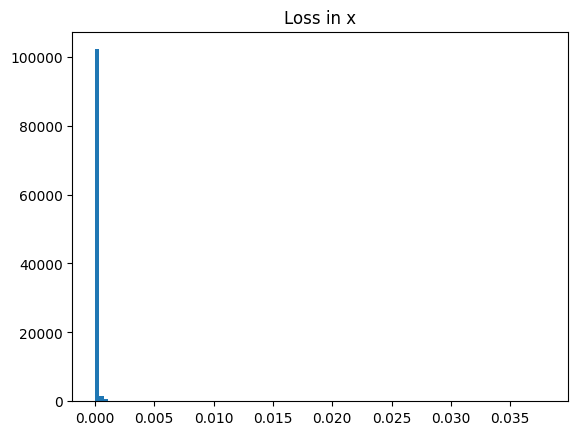

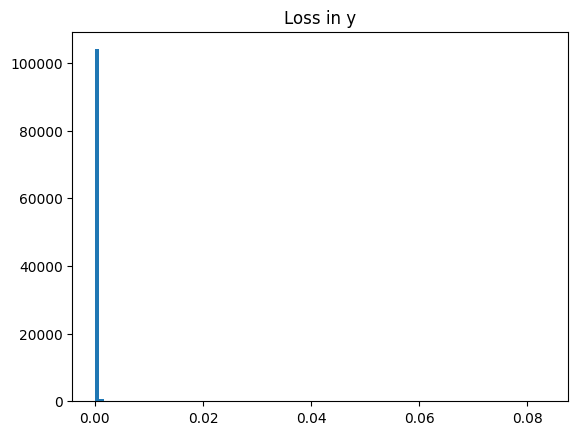

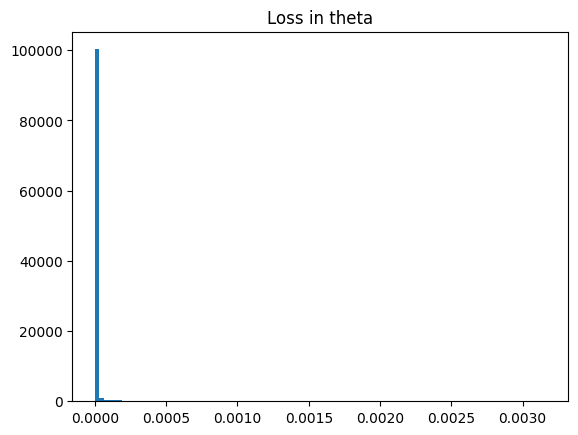

In [24]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


In [10]:
# get outlier indexes
outlier_indexes = np.where((loss_x > 0.1) | (loss_y > 0.1) | (loss_theta > 0.1))[0]

print("outlier indexes", outlier_indexes)

outlier indexes []


In [26]:
for i in outlier_indexes:
    print("outlier", i)
    print("s0", s0_tensor[i])
    print("s1", s1_tensor[i])
    print("s1_pred", s1_pred[i])
    print("action_pred", action_pred[i])

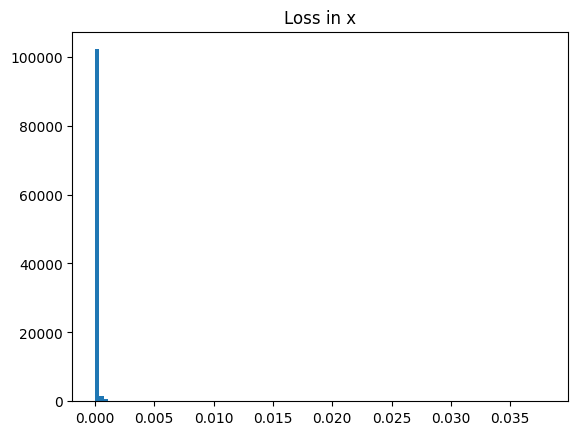

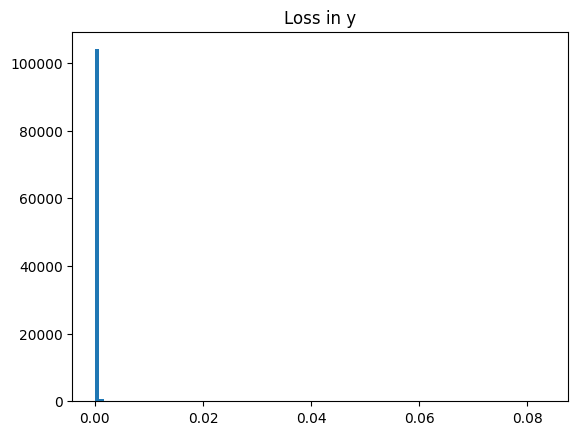

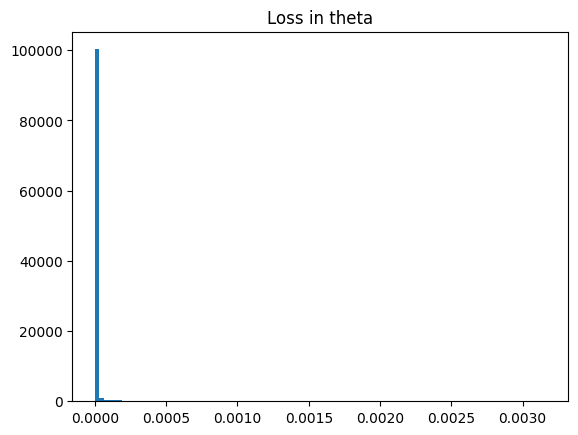

In [27]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()


Let's try visualizing our IDM by having it follow a track from start to finish.

In [11]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return Action(steering.item(), throttle.item())


### Trajectory Replay

In [12]:
scenarios = extract_scenarios_file(getFiles(WAYMO_DATA_PATH)[0])

2023-09-08 20:26:29.260852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 20:26:29.280576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 20:26:29.280778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
scenario = scenarios[2]
trajectory = trajectories[2]
# reset
env = InMemoryScenarioEnv(config={"use_render": True, "manual_control": False}, s=scenario)

[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: [dashboard: VehiclePanel(), main_camera: MainCamera(1200, 900)]
[INFO] Render Mode: onscreen


In [17]:
env.reset()
# set the initial state
for i in range(len(trajectory)):
    st = trajectory[i]
    env.vehicle.set_position(scenario.tracks[scenario.ego_track_index].states[i].position)
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)
    env.step([0, 0])

97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f99c2b48ad0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f99c2b48250>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f99c2b4a8d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f99c2b4be10>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f99c2b4ae10>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f99d41a18d0>, entry

### Closed Loop IDM

In [18]:
with torch.no_grad():
    # reset
    env.reset()

    st = trajectory[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(trajectory)-1):
        # st0 = scenario.tracks[scenario.ego_track_index].states[i]
        # st1 =  scenario.tracks[scenario.ego_track_index].states[i]
        st0 = trajectory[i]
        st1 = trajectory[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)(Observation(st0_pred, st1))
        env.step([action.steer, action.throttle])
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f9a1ebafb10>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f99c6764c50>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f99c6764dd0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f99c6764e90>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f99d4153cd0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f99d4153610>, entry

### Open Loop IDM

In [16]:
with torch.no_grad():
    # reset
    env.reset()
    st = trajectory[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(trajectory)-1):
        st0 = trajectory[i]
        st1 = trajectory[i+1]
        action = IDMPolicy(idm)(Observation(st0, st1))
        env.step(np.array([action.steer, action.throttle]))
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f9e99c48090>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f9eadc745d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f9e9de266d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f9ea0f0e990>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f9ea0fbc310>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f9ea0fbd7d0>, entry

In [19]:
env.close()

In [20]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

In [21]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(np.array(s_pred.velocity) - np.array(s_true.velocity)) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0 = o.state
    s1 = o.next_state
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

def run_game_est(tm:TransitionModel, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    device = deviceof(tm)
    s0 = o.state
    s1 = o.next_state
    a = policy(o)
    with torch.no_grad():
        s1_pred_tensor = tm(state_batch_to_tensor([s0],device), action_batch_to_tensor([a],device)).detach().cpu().numpy()[0]
    s1_pred = State(velocity=s1_pred_tensor[:2], heading=np.arctan2(s1_pred_tensor[3], s1_pred_tensor[2]))
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred


In [22]:
import random
random.seed(42)
idm_test_set = random.sample(idm_train_data, 500)

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


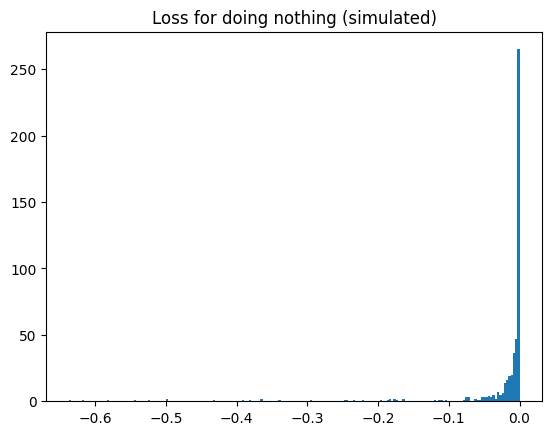

mean -0.02688738814984228
median -0.0025635060638016342


In [23]:
def null_policy(_:Observation) -> Action:
    return Action(0, 0)

# test loss function
do_nothing_loss = []
for obs in idm_test_set:
    _, rew, _ = run_game(env, null_policy, obs)
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

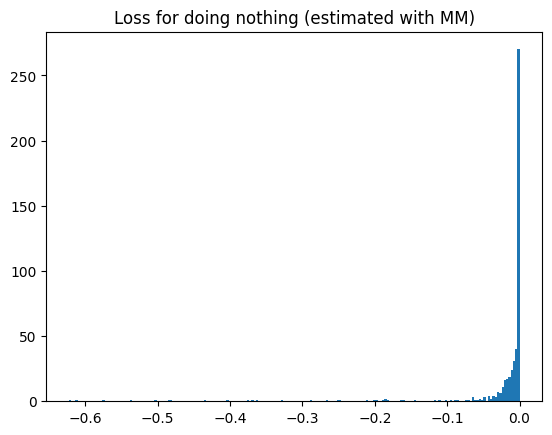

mean -0.026279639497073484
median -0.002181061330686704


In [24]:
# test loss function
do_nothing_loss_est = []
for obs in idm_test_set:
    _, rew, pred_s1 = run_game_est(tm, null_policy, obs)
    do_nothing_loss_est.append(rew)

plt.title("Loss for doing nothing (estimated with MM)")
plt.hist(do_nothing_loss_est, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss_est))
print("median", np.median(do_nothing_loss_est))

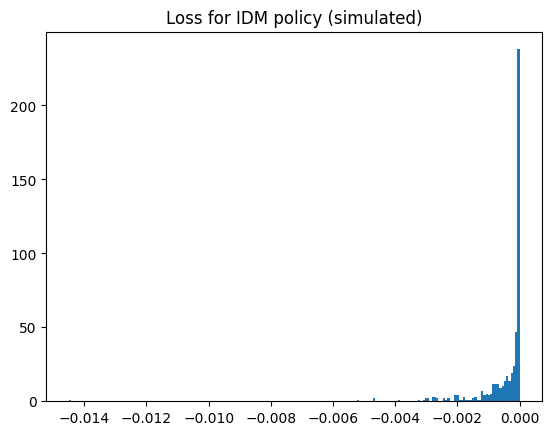

mean -0.00045271369908492476
median -8.237808587658819e-05


In [25]:
# test loss function
idm_loss = []
for o in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), o)
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

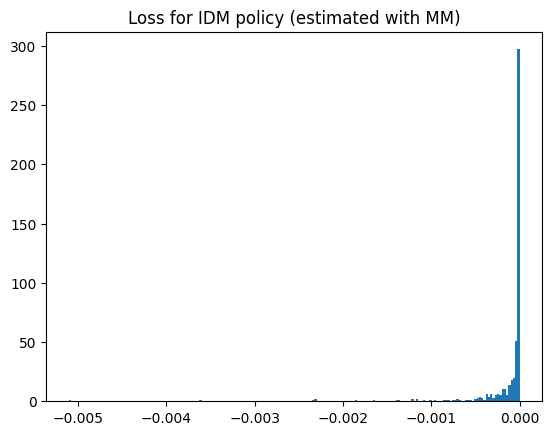

mean -0.00013292660085050906
median -1.5157365896341465e-05


In [26]:
# test loss function
idm_loss_est = []
for o in idm_test_set:
    _, rew, _ = run_game_est(tm, IDMPolicy(idm), o)
    idm_loss_est.append(rew)

plt.title("Loss for IDM policy (estimated with MM)")
plt.hist(idm_loss_est, bins=200)
plt.show()
print("mean", np.mean(idm_loss_est))
print("median", np.median(idm_loss_est))

In [ ]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()

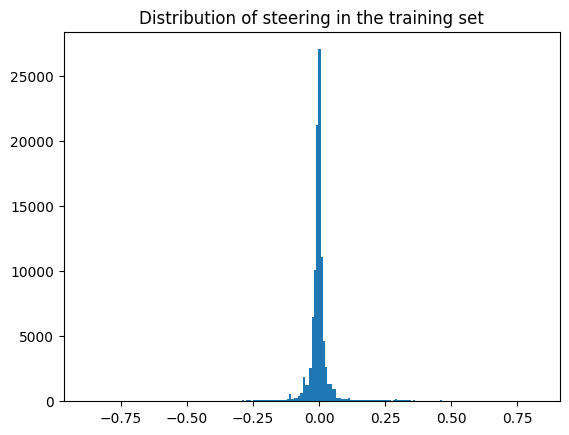

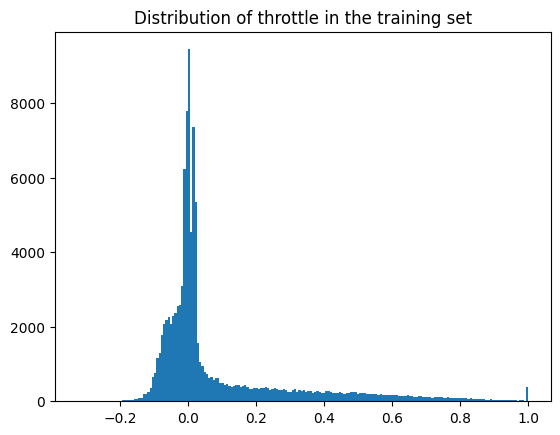

In [31]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()